# Aiyagari (1994) in Continuous Time

#### By [SeHyoun Ahn](http://www.princeton.edu/~sehyouna/) and [Benjamin Moll](http://www.princeton.edu/~moll/)

The material in this notebook is based on [Achdou et al. (2015) "Heterogeneous Agent Models in Continuous Time"](http://www.princeton.edu/~moll/HACT.pdf) and follows closely the material in the paper's [online Appendix](http://www.princeton.edu/~moll/HACTproject/HACT_Numerical_Appendix.pdf). Additional codes (mainly in MATLAB) can be found [here](http://www.princeton.edu/~moll/HACTproject.htm).

We begin by importing some packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

## Aiyagari Economy
The economy can be represented by the following system of equations which we aim to solve numerically:
$$
\begin{align*}
\rho v_1(a) &=  \max_c \ u(c) + v_1'(a)(wz_1 + ra - c) + \lambda_1(v_2(a) - v_1(a))\\
\rho v_2(a) &=  \max_c \ u(c) + v_2'(a)(wz_2 + ra - c) + \lambda_2(v_1(a) - v_2(a))\\
0 &= - \frac{d}{da}[s_1(a)g_1(a)] - \lambda_1 g_1(a) + \lambda_2 g_2(a)\\
0 &= - \frac{d}{da}[s_2(a)g_2(a)] - \lambda_2 g_2(a) + \lambda_1 g_1(a)\\
1 &= \int_{\underline{a}}^\infty g_1(a)da + \int_{\underline{a}}^\infty g_2(a)da\\
K &= \int_{\underline{a}}^\infty a g_1(a)da + \int_{\underline{a}}^\infty a g_2(a)da\\
r &= \alpha K^{\alpha-1} - \delta, \quad w=(1-\alpha)K^\alpha
\end{align*}
$$

where $z_1$ &lt; $z_2$ and $s_j(a)=wz_j + ra -c_j(a)$ and $c_j(a) = (u')^{-1}(v_j(a))$ are optimal savings and consumption. Finally, there is a state constraint $a\geq \underline{a}$. The first order condition $u'(c_j(\underline{a}))=v'_j(\underline{a})$ still holds at the borrowing constraint. However, in order to respect the constraint we need $s_j(\underline{a}) = z_j + ra - c_j(\underline{a}) \geq 0$. Combining this with the FOC, the state constraint motivates a boundary condition
$$
\begin{align} v_j'(\underline{a}) \geq u'(z_j + r \underline{a}), \quad j=1,2 \end{align}
$$

We use a finite difference method, an in particular an "implicit upwind scheme." The details are explained in the paper's [online Appendix](http://www.princeton.edu/~moll/HACTproject/HACT_Numerical_Appendix.pdf). We here provide a brief summary. We approximate the functions $(v_1,v_2,g_1,g_2)$ at $I$ discrete points in the space dimension, $a_i,i=1,...,I$. We use equispaced grids, denote by $\Delta a$ the distance between grid points, and use the short-hand notation $v_{i,j} \equiv v_j(a_i)$ and so on. The derivative $v_{i,j}'=v_j'(a_i)$ is approximated with either a forward or a backward difference approximation
$$
\begin{align*}
v_j'(a_i) \approx \frac{v_{i+1,j} - v_{i,j}}{\Delta a} \equiv v_{i,j,F}' \\
v_j'(a_i) \approx \frac{v_{i-1,j} - v_{i,j}}{\Delta a} \equiv v_{i,j,B}'
\end{align*}
$$
An upwind scheme means that we approximate the derivative $v_j'(a_i)$ with a forward difference approximation whenever the drift of the state variable is positive and the backward difference approximation whenever it is negative. An implicit scheme is a particular way of iterating on the value function.

In a nutshell, the discretized HJB equation can be written as 
$$\rho v = u + \mathbf{A} v$$
where $\mathbf{A}$ is $N \times N$ transition matrix with $N = 2 \times I$ and where $I$ is the number of wealth grid points. The matrix $\mathbf{A}$ depends on $v$, i.e. this is a nonlinear problem and we therefore need to iterate (this is where the implicit scheme comes in). The matrix $\mathbf{A}$ has the interpretation of a Poisson transition matrix (or "intensity matrix") on the discretized state space $(a_i,z_j)$.

Similarly, one can show that the discretized Kolmogorov Forward equation is
$$0 = \mathbf{A}^T g$$
which is an eigenvalue problem. That is, the discretized stationary distribution $g$ is the eigenvector corresponding to a zero eigenvalue of the transpose of the Poisson transition matrix $\mathbf{A}$. The transpose comes from the fact that the differential operator in the KF equation is the "adjoint" of the operator in the HJB equation. And an "adjoint" is the infinite-dimensional analogue of matrix transpose.

The matrix $\mathbf{A}$ is found from the discretized HJB equation. Skipping a number of steps it can be written as
$$
\begin{align*}
&\frac{v^{n+1}_{i,j} - v^{n}_{i,j}}{\Delta} + \rho v_{i,j}^{n+1} = u(c_{i,j}^n) + v_{i-1,j}^{n+1}x_{i,j}   +  v^{n+1}_{i,j} y_{i,j} + v_{i+1,j}^{n+1} z_{i,j} + v_{i,-j}^{n+1}\lambda_j \quad \mbox{where}\\
&x_{i,j} = -\frac{(s^n_{i,j,B})^-}{\Delta a},\\
&y_{i,j} = - \frac{(s^n_{i,j,F})^+}{\Delta a}  +  \frac{ (s^n_{i,j,B})^-}{\Delta a} - \lambda_j,\\
&z_{i,j} = \frac{(s^n_{i,j,F})^+}{\Delta a}
\end{align*}
$$
where $s^n_{i,j,F}$ and $s^n_{i,j,B}$ are the discretized optimal household savings at grid points $(a_i,z_j)$ using forward and backward approximations, and where for any number $x$, the notation $x^+$ means "the positive part of $x$", i.e. $x^+ = \max\{x,0\}$ and analogously $x^{-} = \min\{x,0\}$. This part is what makes it an upwind scheme.


This is a system of $2 \times I$ linear equations which can be written in matrix notation as:
\begin{equation}\frac{1}{\Delta}(v^{n+1} - v^n) + \rho v^{n+1} = u^n + \mathbf{A}^n v^{n+1} \end{equation}
where
$$\mathbf{A}^n = \left[\begin{matrix}y_{1,1} & z_{1,1} & 0 & \cdots & 0 & \lambda_1 & 0 & 0 & \cdots & 0 \\ x_{2,1} & y_{2,1} & z_{2,1} & 0 & \cdots & 0 & \lambda_1 & 0 & 0 & \cdots \\ 0 & x_{3,1} & y_{3,1} & z_{3,1} & 0 & \cdots & 0 & \lambda_1 & 0 & 0 \\ \vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\ 0 & \ddots & \ddots & x_{I,1} & y_{I,1} & 0 & 0 & 0 & 0 & \lambda_1\\  \lambda_2 & 0 & 0 & 0 & 0 & y_{1,2} & z_{1,2} & 0 & 0 & 0 \\ 0 & \lambda_2 & 0 & 0 & 0 & x_{2,2} & y_{2,2} & z_{2,2} & 0 & 0  \\ 0 & 0 & \lambda_2 & 0 & 0 & 0 & x_{3,2}  & y_{3,2} & z_{3,2} & 0 \\ 0 & 0 & \ddots & \ddots & \ddots & \ddots & \ddots  & \ddots & \ddots & \ddots \\ 0 & \cdots & \cdots & 0 & \lambda_2 & 0 & \cdots  & 0 & x_{I,2} & y_{I,2}  \end{matrix}\right], \quad u^n = \left[\begin{matrix} u(c_{1,1}^n)\\ \vdots \\ \vdots \\ u(c_{I,1}^n)\\  u(c_{1,2}^n) \\ \vdots \\ \vdots \\ u(c_{I,2}^n)\end{matrix}\right]$$
This system can in turn be written as
$$
\begin{align*}\mathbf{B}^n v^{n+1} = b^n, \quad \quad \mathbf{B}^n = \left(\frac{1}{\Delta} + \rho\right)\mathbf{I} - \mathbf{A}^n, \quad  b^n = u^n + \frac{1}{\Delta}v^n \end{align*}
$$
This system of linear equations can be solved very efficiently using sparse matrix routines. In Python this is implemented with the function "spsolve()."

#### Summary of Algorithm
First consider the algorithm for solving the HJB equations. Guess $v^0_{i,j},i=1,...,I,j=1,2$ and for $n=0,1,2,...$ follow
1. Compute $(v^n_{i,j})'$ using the current guess of the value function and the upwind scheme (forward difference when drift is positive, backward difference when drift is negative)
2. Compute $c^n$ from $c_{i,j}^n = (u')^{-1}[(v_{i,j}^n)']$
3. Find $v^{n+1}$ by solving the system of linear equations involving the matrix $\mathbf{A}$ described above (implicit scheme)
4. If $v^{n+1}$ is close enough to $v^n$: stop. Otherwise, go to step 1.

After solving the HJB equations, solving the Kolmogorov Forward equation: simply solve the eigenvalue problem $0=\mathbf{A}^T g$ described above. That is, once the HJB equation is solved, we basically get the Kolmogorov Forward equation "for free."

#### Overview of Code
Given this overview of the algorithm, we now briefly describe the code. As in the discrete-time version, we define a "household" class. Household objects contain all the data relevant to solving a household's decision problem. The household class  contain:
* economic parameters (e.g., w, r)
* utility paramters (e.g., discount factor $\rho$)
* asset and skill level represented on a grid

The household's decision problem is solved by invoking the function solve_bellman() which solves the HJB equation given the relevant parameters saving the value-function as v.

We also include the stationary wealth distribution of households in the household object. This is a natural thing to do since this stationary distribution is computed using the household's decision rule. Hence, after computing the decision problem of households, the stationary distribution can be found by invoking compute_stationary_distribution()

The definition of the household class is given below.

In [2]:
class Household(object):
    def __init__(self,
                 r=0.03,         # interest rate
                 w=1,            # wages
                 rho=0.04,       # discount factor
                 a_min=1e-10,    # minimum asset amount
                 pi=[[-0.1, 0.1], [0.1, -0.1]],  # poisson Jumps
                 z_vals=[0.1, 1.0],                # exogenous income states
                 a_max=40,
                 a_size=1000,    # number of asset grid points
                 delta=1000.0):
        # Initialize values, and set up grids over a and z
        self.r, self.w, self.rho = r, w, rho
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.da = (self.a_max-self.a_min)/(self.a_size-1)
        self.k = 10
        self.pi = np.asarray(pi)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)
        self.a_vals = np.linspace(self.a_min, self.a_max, self.a_size)
        self.n = self.a_size * self.z_size
        self.delta = delta

        # Initial Guess of Value Function
        self.v = np.log(np.tile(self.a_vals,(self.z_size,1))*self.r
                        +self.w*np.tile(self.z_vals,(self.a_size,1)).transpose())/self.rho
        
        # Build skill_transition, the matrix summarizing transitions due to the Poisson income shocks
        # This is analogous to the Q matrix in the discrete time version of the QuantEcon Aiyagari model
        self.z_transition = sparse.kron(self.pi,sparse.eye(self.a_size))
        
        # Preallocation
        self.v_old = np.zeros((self.z_size,self.a_size))
        self.g = np.zeros((self.z_size,self.a_size))
        self.dv = np.zeros((self.z_size,self.a_size-1))
        self.cf = np.zeros((self.z_size,self.a_size-1))
        self.c0 = np.zeros((self.z_size,self.a_size))
        self.ssf = np.zeros((self.z_size,self.a_size))
        self.ssb = np.zeros((self.z_size,self.a_size))
        self.is_forward = np.zeros((self.z_size,self.a_size),'bool')
        self.is_backward = np.zeros((self.z_size,self.a_size),'bool')
        self.diag_helper = np.zeros((self.z_size,self.a_size))        
        self.A = self.z_transition.copy()
        self.B = self.z_transition.copy()
        self.AT = self.z_transition.copy()

    def set_prices(self, r, w):
        """
        Resets prices
        Calling the method will resolves the Bellman Equation.
        
        Parameters:
        -----------------
        r : Interest rate
        w : wage
        """
        self.r, self.w = r, w
        self.solve_bellman()

    def reinitialize_v(self):
        """
        Reinitializes the value function if the value function
        became NaN
        """
        self.v = np.log(np.tile(self.a_vals,(self.z_size,1))*self.r
                        +self.w*np.tile(self.z_vals,(self.a_size,1)).transpose())/self.rho

    def solve_bellman(self,maxiter=100,crit=1e-6):
        """
        This function solves the decision problem with the given parameters
        
        Parameters:
        -----------------
        maxiter : maximum number of iteration before haulting value function iteration
        
        crit : convergence metric, stops if value function does not change more than crit
        """
        dist=100.0
        for i in range(maxiter):
            # compute saving and consumption implied by current guess for value function, using upwind method
            self.dv = (self.v[:,1:]-self.v[:,:-1])/self.da
            self.cf = 1.0/self.dv
            self.c0 = np.tile(self.a_vals,(self.z_size,1))*self.r \
                            +self.w*np.tile(self.z_vals,(self.a_size,1)).transpose()
            # computes savings with forward forward difference and backward difference
            self.ssf[:,:-1] = self.c0[:,:-1]-self.cf
            self.ssb[:,1:] = self.c0[:,1:]-self.cf
            # Note that the boundary conditions are handled implicitly as ssf will be zero at a_max and ssb at a_min 
            self.is_forward = self.ssf>0
            self.is_backward = self.ssb<0
            # Update consumption based on forward or backward difference based on direction of drift
            self.c0[:,:-1] += (self.cf-self.c0[:,:-1])*self.is_forward[:,:-1]
            self.c0[:,1:] += (self.cf-self.c0[:,1:])*self.is_backward[:,1:]
            self.c0 = np.log(self.c0)
            
            # Build the matrix A that summarizes the evolution of the process for (a,z)
            # This is a Poisson transition matrix (aka intensity matrix) with rows adding up to zero
            self.A = self.z_transition.copy()
            self.diag_helper = (-self.ssf*self.is_forward/self.da \
                               + self.ssb*self.is_backward/self.da).reshape(self.n)
            self.A += sparse.spdiags(self.diag_helper,0,self.n,self.n)
            self.diag_helper = (-self.ssb*self.is_backward/self.da).reshape(self.n)
            self.A += sparse.spdiags(self.diag_helper[1:],-1,self.n,self.n)
            self.diag_helper = (self.ssf*self.is_forward/self.da).reshape(self.n)
            self.A += sparse.spdiags(np.hstack((0,self.diag_helper)),1,self.n,self.n)

            # Solve the system of linear equations corresponding to implicit finite difference scheme
            self.B = sparse.eye(self.n)*(1/self.delta + self.rho) - self.A
            self.b = self.c0.reshape(self.n,1) + self.v.reshape(self.n,1)/self.delta
            self.v_old = self.v.copy()
            self.v = spsolve(self.B,self.b).reshape(self.z_size,self.a_size)

            # Compute convergence metric and stop if it satisfies the convergence criterion
            dist = np.amax(np.absolute(self.v_old-self.v).reshape(self.n))
            if dist < crit:
                break

    def compute_stationary_distribution(self):
        """
        Solves for the stationary distribution given household decision rules
        
        Output:
        Capital level from the stationary distribution
        """        
        self.AT = self.A.transpose().tocsr()

        # The discretized Kolmogorov Forward equation AT*g=0 is an eigenvalue problem
        # AT is singular because one of the equation is the distribution adding
        # up to 1. Here we solve the eigenvalue problem by setting g(1,1)=0.1
        # and the equation is solved relative to that value.
        # Alternatively, one could use a routine for solving eigenvalue problems.
        b = np.zeros((self.n,1))
        b[0] = 0.1
        self.AT.data[1:self.AT.indptr[1]] = 0
        self.AT.data[0] = 1.0
        self.AT.indices[0] = 0
        self.AT.eliminate_zeros()
        self.g = spsolve(self.AT,b).reshape(self.z_size,self.a_size)
        
        # Since g was solved taking one of g(1,1) as given, g needs to be
        # renormalized to add up to 1
        self.g = self.g/np.sum(self.g)
        return np.sum(self.g*(np.tile(self.a_vals,(self.z_size,1))))

For example, if interest rate is 0.05 and wage is 1, we can initialize a household, solve it decision problem, and find the stationary distribution by running

In [3]:
am=Household(r=0.05,w=1)
am.solve_bellman()
am.compute_stationary_distribution()

39.104796555465526

Once, a household object is created, the object can be reused to solve a different problem by changing parameters. For example, if the interest rate were to change to 0.03 and wage to 0.9, the new problem can be solved by setting parameters directly by

In [4]:
am.r=0.03
am.w=0.9

and running

In [5]:
am.solve_bellman()
am.compute_stationary_distribution()

5.9052049733275469

Alternately, a helper function can be created to automate this process. For example, set_prices(r,w) function resets parameters, and solves the decision problem again. For example, you can run the following to the same effect.

In [6]:
am.set_prices(r=0.03,w=0.9)
am.compute_stationary_distribution()

5.9052051500667417

Given the household class, solving for the steady state becomes really simple. To find the equilibrium, we solve for the capital level that is consistent with household's decisions.

Before solving for the actual steady state, we can visualize the capital demand and capital supply.

In [7]:
A = 2.5
N = 0.05
alpha = 0.33

def r_to_w(r):
    return A * (1 - alpha) * (alpha / (1 + r))**(alpha / (1 - alpha))

def rd(K):
    return A * alpha * (N / K)**(1 - alpha)

def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    am : Household
        An instance of the Household class
    r : float
        The interest rate
    """
    w = r_to_w(r)

    # Set new prices and solve the Bellman equation
    am.set_prices(r, w)

    # Compute the stationary distribution and capital
    return am.compute_stationary_distribution()

We make a grid of interest rate points, and plot the resulting capital.

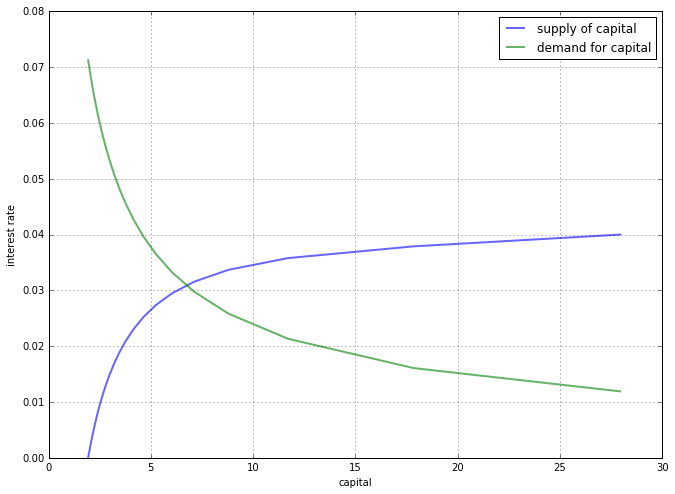

In [8]:
num_points = 20
r_vals = np.linspace(0.0, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am,r)

# Plot supply and demand of capital
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')
plt.show()

Finally, the equilibrium interest rate can be found by using the bisection method, and we can see the equilibrium distribution of assets.

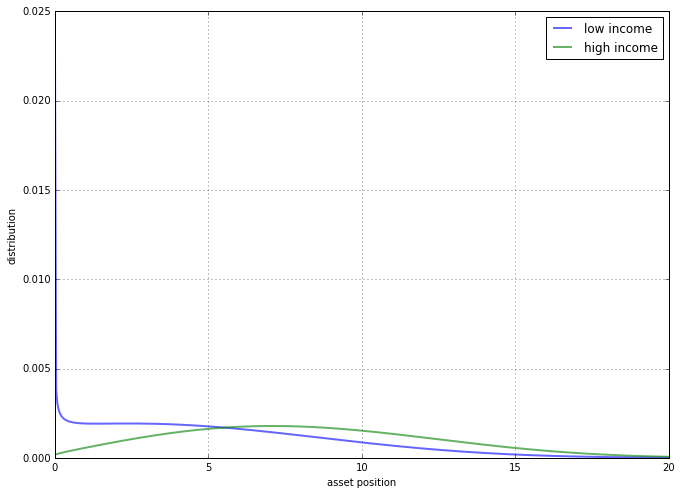

In [9]:
# Set parameters for bisection method
crit = 1e-6
r_min = 0.02
r_max = 0.04
r = 0.03

# Bisection loop
for i in range(100):
    am.set_prices(r,r_to_w(r))
    r_new = rd(am.compute_stationary_distribution())
    if np.absolute(r_new-r)<crit:
        break
    elif r_new > r:
        r_min = r
        r = (r_max+r_min)/2.
    else:
        r_max = r
        r = (r_max+r_min)/2.

# Plot stationary distribution at the equilibrium
fig, ax = plt.subplots(figsize=(11, 8))
n=500                      # Determine the max asset level to show in the plot
ax.plot(am.a_vals[0:n], am.g[0,0:n], lw=2, alpha=0.6, label='low income')
ax.plot(am.a_vals[0:n], am.g[1,0:n], lw=2, alpha=0.6, label='high income')
ax.grid()
ax.set_xlabel('asset position')
ax.set_ylabel('distribution')
ax.legend(loc='upper right')
plt.show()